In [1]:
# INIT

import ipaddress
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
from collections import Counter
import ast
import matplotlib.colors as mcolors
import maxminddb
from itertools import combinations
from constants import servers

def ip_to_subnet(ip):
    return str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"

def ip_to_asn(ip_address, db_path='data/external/GeoLite2-ASN.mmdb'):
    try:
        with maxminddb.open_database(db_path) as reader:
            result = reader.get(ip_address)
            return result['autonomous_system_organization']
    except Exception as e:
        return None
   
def set_plt_latex_format():
    plt.rcParams.update({
        "font.size": 12,          # Base font size
        "axes.titlesize": 12,     # Title size
        "axes.labelsize": 10,     # Axis label size
        "xtick.labelsize": 10,    # X-tick label size
        "ytick.labelsize": 10,    # Y-tick label size
        "legend.fontsize": 12,    # Legend font size
        "figure.titlesize": 12,    # Figure title size
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

def retrieve_color_palette(n_colors=10, blends=None):
    if blends is None or len(blends) < 2:
        blends = ['#c40d1e', '#9013fe']  # Default red to purple
    
    # Convert all hex colors to RGB
    rgb_colors = [np.array(mcolors.hex2color(color)) for color in blends]
    
    # Calculate how many segments we need
    segments = len(blends) - 1
    colors_per_segment = n_colors // segments
    extra_colors = n_colors % segments  # Distribute remainder colors among segments
    
    # Create the color list
    colors = []
    
    for i in range(segments):
        start_color = rgb_colors[i]
        end_color = rgb_colors[i+1]
        
        # Calculate how many colors for this segment (distribute remainder)
        segment_colors = colors_per_segment + (1 if i < extra_colors else 0)
        
        # Create colors for this segment
        for j in range(segment_colors):
            if segment_colors > 1:  # Avoid division by zero
                t = j / (segment_colors - 1)
            else:
                t = 0
            color = tuple(start_color + (end_color - start_color) * t)
            colors.append(color)
    
    # Create matplotlib colormap and seaborn palette
    custom_cmap = mcolors.ListedColormap(colors)
    #custom_palette = sns.color_palette(colors, n_colors=len(colors))
    
    return colors, custom_cmap#, custom_palette

In [2]:
default_port = "18080"

# in complete script do: for node in servers.keys()
node = 'sfo'

folder_path=Path(f"data/packets/{node}")
my_ip = servers[node]

peer_packets_df = pd.read_parquet(f'data/dataframes/peer_packets_{node}.parquet')
peers_df = pd.read_parquet(f"data/dataframes/peers_{node}.parquet")

In [3]:
# BASIC SUMMARY
num_unique_ips = peer_packets_df['source_ip'].nunique() # number of unique IPs I have opened a connection to
num_unique_neighbors = peers_df['ip'].nunique() # number of unique neighbors extracted from all peer lists
num_tot_packets = len(peer_packets_df)
num_peer_lists = peers_df[peers_df['source_ip'] != my_ip]['pl_identifier'].nunique()
all_unique_ips = pd.DataFrame({
    'ip': pd.concat([peer_packets_df['source_ip'], peers_df['ip']]).unique()
})

print(f"For node {node}: \n    {num_tot_packets} packets, \n    connected to {num_unique_neighbors} unique IPs, \n    collected {num_unique_ips} from {num_peer_lists}.")
print(f"totals: {len(all_unique_ips)} unique IPs")

For node sfo: 
    3573738 packets, 
    connected to 10934 unique IPs, 
    collected 6573 from 135242.
totals: 14401 unique IPs


In [4]:
# EVIDENT CONNECTION LEVEL ANOMALIES
# last_seen timestamp
lastseen_sources = peers_df[peers_df['last_seen'].notna()]['source_ip'].unique().tolist() 
num_last_seen_sources = len(lastseen_sources)
# support_flags
support_flags_sources = peer_packets_df[(peer_packets_df['command'] == '1001') & (peer_packets_df['support_flags'].isna())]['source_ip'].unique().tolist()
num_sup_flag_sources = len(support_flags_sources)

print(f"{num_last_seen_sources} unique IPs sent last_seen timestamp")
print(f"{num_sup_flag_sources} did not set their support flags")

63 unique IPs sent last_seen timestamp
733 did not set their support flags


In [5]:
# CONNECTION ANOMALIES: Ping, TS Latency,  

def get_connection_info(row, my_ip, default_port):
    # Determine if outgoing (my_ip uses ephemeral port) or incoming (peer uses ephemeral port)
    if row['source_ip'] == my_ip and row['source_port'] != default_port:
        # Outgoing: my port is ephemeral
        return 'outgoing', row['dst_ip'], f"{my_ip}:{row['source_port']}->{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] != my_ip and row['dst_port'] != default_port:
        # Outgoing: peer is responding, but connection was initiated by me
        return 'outgoing', row['source_ip'], f"{my_ip}:{row['dst_port']}->{row['source_ip']}:{row['source_port']}"
    elif row['source_ip'] == my_ip and row['source_port'] == default_port:
        # Incoming: my port is default
        return 'incoming', row['dst_ip'], f"{my_ip}:{default_port}<-{row['dst_ip']}:{row['dst_port']}"
    elif row['source_ip'] != my_ip and row['dst_port'] == default_port:
        # Incoming: I'm responding, but connection was initiated by peer
        return 'incoming', row['source_ip'], f"{my_ip}:{default_port}<-{row['source_ip']}:{row['source_port']}"
    
def group_per_connection(peer_packets_df, my_ip, default_port):
    all_data = peer_packets_df.copy()
    connection_info = all_data.apply(get_connection_info, axis=1, args=(my_ip, default_port))
    all_data['direction'] = [info[0] for info in connection_info]
    all_data['peer_ip'] = [info[1] for info in connection_info]
    all_data['connection_key'] = [info[2] for info in connection_info]
    
    # Sort by connection and timestamp
    all_data = all_data.sort_values(['connection_key', 'timestamp'])
    all_data['connection_key_cat'] = all_data['connection_key'].astype('category')
    all_data['prev_connection'] = all_data['connection_key_cat'].shift(1)
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()
    
    # Identify connection breaks
    all_data['is_break'] = (
        (all_data['connection_key_cat'] != all_data['prev_connection']) |
        (all_data['time_diff'] > 120) |
        (all_data['time_diff'].isna())
    )
    all_data['connection_id'] = all_data['is_break'].cumsum()
    grouped = all_data.groupby('connection_id')
    
    # initial conn_df with basic info
    valid_conn_ids = grouped.size()[grouped.size() >= 1].index
    conn_info = []
    
    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        source_ips = np.array(conn['source_ip'])
        if len(source_ips) == 1 and source_ips[0] == my_ip:
            continue

        source_ip = conn['source_ip'].iloc[0]
        timestamps = np.array(conn['timestamp'])
        duration = timestamps[-1] - timestamps[0]

        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        

        my_ip_mask = (source_ips == my_ip)
        peer_ip_mask = (source_ips != my_ip)
        req_mask = (monero_flags == '1')
        resp_mask = (monero_flags == '2')
        ts_mask = (commands == '1002')

        # check for tcp anomalies
        my_ts_resp_mask = (my_ip_mask & resp_mask & ts_mask)
        peer_ts_req_mask = (peer_ip_mask & req_mask & ts_mask)
        peer_diff = len(commands[my_ts_resp_mask]) - len(commands[peer_ts_req_mask])
        peer_ts_resp_mask = (peer_ip_mask & resp_mask & ts_mask)
        my_ts_req_mask = (my_ip_mask & req_mask & ts_mask)
        my_diff = len(commands[peer_ts_resp_mask]) - len(commands[my_ts_req_mask])
        tcp_anomaly = False
        if peer_diff > 2 or my_diff < -2:
            tcp_anomaly = True

        # calculate timed sync latency
        ts_series = pd.Series(timestamps[peer_ts_req_mask])
        latency = None
        if not tcp_anomaly and len(ts_series) > 2:
            differences = ts_series.diff().dt.total_seconds().dropna()
            latency = min(differences.median(), differences.mean())

        # check for Ping flooding
        ping_mask = (commands == '1003')
        peer_ping_mask = (peer_ip_mask & ping_mask)
        ping_series = pd.Series(timestamps[peer_ping_mask])
        ping_frequency = None
        if len(ping_series) > 2:
            differences = ping_series.diff().dt.total_seconds().dropna()
            ping_frequency = max(differences.median(), differences.mean())

        # check for completed handshake
        handshake_mask = (commands == '1001')
        my_handshakes = (handshake_mask & my_ip_mask)
        peer_handshakes = (handshake_mask & peer_ip_mask)
        incomplete_hs = False
        if (len(commands[my_handshakes]) == 0) or (len(commands[peer_handshakes]) == 0):
            incomplete_hs = True

        conn_info.append({
            'connection_id': conn_id,
            'source_ip': source_ip, 
            'tcp_anomaly': tcp_anomaly,
            'initial_command': commands[0],
            'peer_ip': conn['peer_ip'].iloc[0],
            'direction': conn['direction'].iloc[0],
            'duration': duration / pd.Timedelta(seconds=1),
            'total_commands': len(commands),
            'peer_commands': len(commands[peer_ip_mask]),
            'ts_latency': latency,
            'total_pings': len(commands[peer_ping_mask]),
            'incomplete_hs': incomplete_hs,
            'ping_frequency': ping_frequency,
            'req_res_diff': peer_diff,  # my responses minus the peer's requests -> might be higher if wireshark dissector does not catch all requests by the peer 
            'res_req_diff': my_diff     # peer's responses minus my requests -> might be higher if wireshark dissector does not catch all responses
        })

    conn_df = pd.DataFrame(conn_info)
    return grouped, conn_df

grouped, conn_df = group_per_connection(peer_packets_df, my_ip, default_port)



In [6]:
# BEHAVIORAL CONNECTION LEVEL ANOMALIES continues...
conditions = [
    ((conn_df['tcp_anomaly'])),
    ((conn_df['incomplete_hs'])),
    (conn_df['duration'] < 10),
    (conn_df['duration'] < 30),
    ((conn_df['total_pings'] > 1)),                                         # ping_flooding
    (conn_df['ts_latency'] > conn_df['ts_latency'].quantile(0.95)),         # throttled_ts
    ((conn_df['ts_latency'] < conn_df['ts_latency'].quantile(0.6)) & (conn_df['duration'] > conn_df[conn_df['duration'] > 10]['duration'].quantile(0.5))) # average connection duration
]

choices = [
    'incomplete_tcp',
    'incomplete_hs',
    'short_lived_10',
    'short_lived_30',
    'ping_flooding',
    'throttled_ts',
    'standard_average'
]

conn_df['category'] = np.select(conditions, choices, default='standard')

anomalous_categories = ['short_lived_10', 'short_lived_30', 'ping_flooding', 'throttled_ts']

#print(conn_df['category'].value_counts())

for c in anomalous_categories:
    num_connections_of_cat = conn_df['category'].value_counts()[c]
    unique_ips_in_cat = conn_df[conn_df['category'] == c]['source_ip'].unique()
    asns = set()
    for ip in unique_ips_in_cat:
        asns.add(ip_to_asn(ip))
    print(f"Category {c}: {num_connections_of_cat} connections with {len(unique_ips_in_cat)} unique IPs in {len(asns)} ASNs")
    print()

Category short_lived_10: 20483 connections with 2773 unique IPs in 753 ASNs

Category short_lived_30: 506 connections with 200 unique IPs in 109 ASNs

Category ping_flooding: 566 connections with 508 unique IPs in 1 ASNs

Category throttled_ts: 144 connections with 99 unique IPs in 54 ASNs



Category short_lived_10: 24447 connections with 2885 unique IPs in 758 ASNs

Category short_lived_30: 691 connections with 247 unique IPs in 125 ASNs

Category ping_flooding: 576 connections with 503 unique IPs in 1 ASNs

Category throttled_ts: 150 connections with 100 unique IPs in 55 ASNs


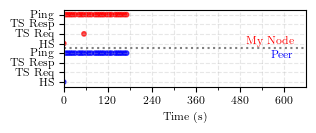

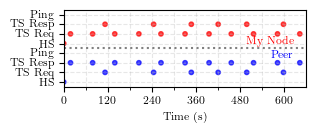

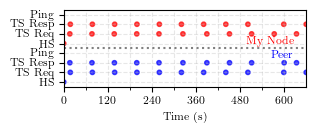

In [7]:
# RANDOM PLOTS
def get_command_category(cmd, flag, source, my_ip):
    """Map commands and flags to categories"""
    if source == my_ip:
        i = 4
    else:
        i = 0
        
    category_map = {
        ('1001', '1'): 1+i,    # Handshake Request
        ('1001', '2'): 1+i,    # HS Resp
        ('1002', '1'): 2+i,    # Timed Sync Request
        ('1002', '2'): 3+i,    # TS Response
        ('1003', '1'): 4+i,    # Ping
        ('1003', '2'): 4+i     # Pong
    }
    
    return category_map.get((cmd, flag), 0)

def setup_axis_appearance(ax, time_duration_seconds, show_ylabel=True):
    """Configure axis appearance for LaTeX paper"""
    category_labels = ['HS', 'TS Req', 'TS Resp', 'Ping', 'HS', 'TS Req', 'TS Resp', 'Ping']

    ax.set_xlabel('Time (s)', fontsize=8)
    #ax.set_ylabel('Command Type', fontsize=10)
    ax.set_xticks(range(0, time_duration_seconds + 1, 120))
    ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8])
    ax.set_yticklabels(category_labels, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_ylim(0.5, 8.5)
    
    ax.set_xlim(0, time_duration_seconds)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add minor grid lines at 60s intervals
    ax.set_xticks(range(0, time_duration_seconds, 60), minor=True)
    ax.grid(True, alpha=0.3, linestyle='--', which='minor')

def plot_command_timeline_subplot(ax, base_commands, base_flags, base_series, base_sources, title, 
                                time_duration_seconds=300, show_ylabel=True):
    """Plot command timeline on given axis"""
    if len(base_series) == 0:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                ha='center', va='center', fontsize=7)
        ax.set_title(title, fontsize=8, pad=8)

        setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
        return
    
    # Convert to seconds from start and filter by duration
    time_seconds = (base_series - base_series.iloc[0]).dt.total_seconds()
    time_mask = time_seconds <= time_duration_seconds
    
    if not time_mask.any():
        ax.text(0.5, 0.5, 'No data in time range', transform=ax.transAxes, 
                ha='center', va='center', fontsize=9)
        ax.set_title(title, fontsize=10, pad=10)
        setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
        return
    
    # Filter data and create categories    
    commands_filtered = base_commands[time_mask]
    flags_filtered = base_flags[time_mask]
    time_filtered = time_seconds[time_mask]
    sources_filtered = base_sources[time_mask]
    
    categories = [get_command_category(cmd, flag, source, my_ip) 
                  for cmd, flag, source in zip(commands_filtered, flags_filtered, sources_filtered)]
    
    #print(f"{title}: {sources_filtered[:2]} : {base_series[:1]}")
    
    colors = ['red' if source == my_ip else 'blue' 
          for source in sources_filtered]

    ax.scatter(time_filtered, categories, c=colors, s=10, alpha=0.7)

    ax.axhline(4.5, color='gray', linestyle=':')

    ax.text(time_duration_seconds * 0.95, 4.7, 'My Node', 
            ha='right', va='bottom', fontsize=8, color='red')
    
    # Add text below the line  
    ax.text(time_duration_seconds * 0.95, 4.3, 'Peer', 
            ha='right', va='top', fontsize=8, color='blue')
    
    #ax.set_title(title, fontsize=10, pad=10, weight='bold')
    if sources_filtered[0] == my_ip:
        direction = 'outgoing'
    else: 
        direction = 'incoming'
    setup_axis_appearance(ax, time_duration_seconds, show_ylabel)
    
# categories to plot
import random

set_plt_latex_format()
categories_to_plot = ['ping_flooding', 'throttled_ts', 'standard_average']  # Modify this array as needed
max_connections_per_type = 1
time_duration_seconds=660

# Add randomness to peer selection
connection_data = {}
used_peers = set()

for category in categories_to_plot:
        
    category_df = conn_df[conn_df['category'] == category]
    
    # Randomly shuffle the connections in this category
    category_df = category_df.sample(frac=1, random_state=random.randint(1, 10000))
    
    connection_data[category] = []
    count = 0
    
    for idx, row in category_df.iterrows():
        if count >= max_connections_per_type:
            break
            
        conn_id = row['connection_id']
        peer_ip = row['peer_ip']

        if peer_ip in used_peers:
            continue
            
        conn = grouped.get_group(conn_id)
        
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        source_ips = np.array(conn['source_ip'])
            
        used_peers.add(peer_ip)
        
        # base commands only interesting as only these are expectable
        base_mask = np.isin(commands, ['1001', '1002', '1003'])
        base_series = pd.Series(timestamps[base_mask])
        
        connection_data[category].append({
            'peer': peer_ip,
            'source_ips': source_ips[base_mask],
            'commands': commands[base_mask],
            'flags': monero_flags[base_mask],
            'series': base_series
        })
        count += 1

# individual plots for each category
for category in connection_data:
    for j, data in enumerate(connection_data[category]):
        fig, ax = plt.subplots(figsize=(3.13, 1))
        
        title = f"{category}_{j+1}\n{data['peer']}-{data['series'].iloc[0]}"
        
        plot_command_timeline_subplot(
            ax, data['commands'], data['flags'], 
            data['series'], data['source_ips'], title, 
            time_duration_seconds, show_ylabel=True
        )
        
        #plt.tight_layout()
        plt.savefig(f'results/graphs/{category}_{j+1}.pdf', bbox_inches='tight', dpi=300)
        plt.show()
        #plt.close()

In [8]:
# PEER LIST DIVERSITY
peers_df['subnet'] = peers_df['ip'].apply(lambda ip: str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24")

def calc_normalized_diversity(ip_list, subnet_list):
    if len(ip_list) < 245:
        return None
    
    unique_subnets = len(set(subnet_list))
    total_ips = len(ip_list)
    
    raw_diversity = unique_subnets / total_ips

    max_possible_subnets = min(total_ips, 256)
    max_diversity = max_possible_subnets / total_ips
    
    # Normalize: actual diversity / maximum possible diversity
    normalized_diversity = raw_diversity / max_diversity
    
    return normalized_diversity

pl_by_source = peers_df.groupby('pl_identifier').agg({
    'ip': lambda x: x.tolist(),
    'subnet': lambda x: x.tolist(),
    'source_ip': 'first',
}).reset_index()

pl_by_source.columns = ['source_pl', 'peer_ips', 'peer_subnets', 'source_ip']

pl_by_source['pl_diversity_normalized'] = pl_by_source.apply(
    lambda row: calc_normalized_diversity(row['peer_ips'], row['peer_subnets']), axis=1
)

pl_by_source = pl_by_source.dropna(subset=['pl_diversity_normalized'])

pl_by_source['actual_subnets'] = pl_by_source['peer_subnets'].apply(lambda x: len(set(x)))

threshold = pl_by_source['pl_diversity_normalized'].quantile(0.05)
low_diversity = pl_by_source[pl_by_source['pl_diversity_normalized'] < threshold]

print(f"{len(low_diversity)} with diversity below {threshold}")
print(f"    promoted peers in a maximum of {low_diversity['actual_subnets'].max()} subnets")
print(f"    median: {low_diversity['actual_subnets'].median()}, mean: {low_diversity['actual_subnets'].mean():.1f}")

print(f"send by {pl_by_source[pl_by_source['pl_diversity_normalized'] < threshold]['source_ip'].nunique()} unique IPs")

89 with diversity below 0.024
    promoted peers in a maximum of 4 subnets
    median: 4.0, mean: 4.0
send by 77 unique IPs


83 with diversity below 0.024
    promoted peers in a maximum of 5 subnets
    median: 4.0, mean: 4.0
send by 78 unique IPs

In [9]:
# NODE ID overlap
def create_peer_id_df(peer_packets_df):
    grouped = peer_packets_df.groupby('peer_id')

    result_df = pd.DataFrame()

    result_df['peer_id'] = grouped['peer_id'].first()

    result_df['source_ips'] = grouped['source_ip'].apply(lambda x: x.dropna().unique().tolist())
    result_df['unique_source_ips'] = grouped['source_ip'].nunique()

    return pd.DataFrame(result_df)

peer_id_df = create_peer_id_df(peer_packets_df)

sus_peer_id_df = peer_id_df[peer_id_df['unique_source_ips'] > 1]

In [10]:
def find_clusters(sus_peer_id_df):
    # Create a mapping from IP to peer_ids that have this IP
    ip_to_peers = {}
    for _, row in sus_peer_id_df.iterrows():
        peer_id = row['peer_id']
        for ip in row['source_ips']:
            if ip not in ip_to_peers:
                ip_to_peers[ip] = set()
            ip_to_peers[ip].add(peer_id)
    
    visited_peers = set()
    clusters = []
    
    for _, row in sus_peer_id_df.iterrows():
        peer_id = row['peer_id']
        if peer_id in visited_peers:
            continue
            
        cluster_peers = set()
        cluster_ips = set()
        queue = [peer_id]
        
        while queue:
            current_peer = queue.pop(0)
            if current_peer in visited_peers:
                continue
                
            visited_peers.add(current_peer)
            cluster_peers.add(current_peer)
            
            # other IPs for this peer
            peer_ips = sus_peer_id_df[sus_peer_id_df['peer_id'] == current_peer]['source_ips'].iloc[0]
            cluster_ips.update(peer_ips)
            
            # all peers that share any of these IPs
            for ip in peer_ips:
                for connected_peer in ip_to_peers[ip]:
                    if connected_peer not in visited_peers:
                        queue.append(connected_peer)
        
        clusters.append({
            'peer_ids': cluster_peers,
            'source_ips': cluster_ips,
            'num_peers': len(cluster_peers),
            'num_ips': len(cluster_ips)
        })
    
    return clusters

clusters = find_clusters(sus_peer_id_df)

print(f"total of {len(clusters)} clusters: ")
for i, cluster in enumerate(clusters):
    if cluster['num_ips'] > 2 or cluster['num_peers'] > 2:
        print(f"    {i+1}: {cluster['num_ips']} IPs, {cluster['num_peers']} peer IDs")

biggest = max(clusters, key=lambda x: x['num_ips'])
print(f"\nBiggest cluster: {biggest['num_ips']} IPs attached to {biggest['num_peers']} peer IDs")


total of 59 clusters: 
    1: 40 IPs, 28 peer IDs
    5: 4 IPs, 2 peer IDs
    9: 3 IPs, 1 peer IDs
    10: 4 IPs, 1 peer IDs
    16: 4 IPs, 2 peer IDs
    17: 3 IPs, 1 peer IDs
    18: 8 IPs, 1 peer IDs
    19: 4 IPs, 3 peer IDs
    31: 466 IPs, 1 peer IDs
    32: 3 IPs, 1 peer IDs
    38: 3 IPs, 1 peer IDs
    40: 3 IPs, 1 peer IDs
    57: 3 IPs, 1 peer IDs
    58: 4 IPs, 1 peer IDs

Biggest cluster: 466 IPs attached to 1 peer IDs


total of 76 clusters: 
    5: 5 IPs, 4 peer IDs
    8: 3 IPs, 2 peer IDs
    10: 3 IPs, 2 peer IDs
    14: 3 IPs, 2 peer IDs
    17: 4 IPs, 3 peer IDs
    18: 5 IPs, 3 peer IDs
    20: 7 IPs, 4 peer IDs
    22: 3 IPs, 1 peer IDs
    24: 4 IPs, 1 peer IDs
    25: 4 IPs, 1 peer IDs
    29: 3 IPs, 1 peer IDs
    31: 5 IPs, 1 peer IDs
    35: 3 IPs, 2 peer IDs
    42: 466 IPs, 1 peer IDs
    50: 5 IPs, 1 peer IDs
    63: 4 IPs, 2 peer IDs
    65: 3 IPs, 1 peer IDs
    66: 3 IPs, 1 peer IDs
    68: 3 IPs, 1 peer IDs
    69: 3 IPs, 2 peer IDs
    71: 4 IPs, 1 peer IDs
    75: 3 IPs, 1 peer IDs

Biggest cluster: 466 IPs attached to 1 peer IDs

In [11]:
# ASN Affiliation
all_unique_ips['subnet'] = all_unique_ips['ip'].apply(lambda ip: str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24")

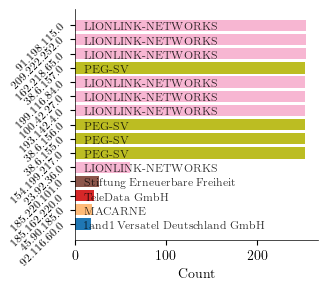

In [16]:
# Get top subnets
top_subnets = all_unique_ips['subnet'].value_counts().head(15)

# Create plot data - only get ASN for top subnets
plot_data = []
for subnet in top_subnets.index:
    count = top_subnets[subnet]
    sample_ip = all_unique_ips[all_unique_ips['subnet'] == subnet]['ip'].iloc[0]
    asn = ip_to_asn(sample_ip)
    plot_data.append({'subnet': subnet, 'count': count, 'asn': asn})

plot_df = pd.DataFrame(plot_data)
plot_df = plot_df.sort_values('count')

# Color mapping and plotting
unique_asns = plot_df['asn'].unique()
cmap = plt.cm.tab20
colors = [cmap(i / len(unique_asns)) for i in range(len(unique_asns))]
asn_color_map = dict(zip(unique_asns, colors))
bar_colors = [asn_color_map[asn] for asn in plot_df['asn']]

fig, ax = plt.subplots(figsize=(3.13, 3))
bars = ax.barh(range(len(plot_df)), plot_df['count'], color=bar_colors)
ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels([subnet.split('/')[0] for subnet in plot_df['subnet']], rotation=45, fontsize=8)

def clean_asn_name(asn):
    return str(asn).replace('&', 'and').replace('_', ' ')

for i, (bar, asn) in enumerate(zip(bars, plot_df['asn'])):
    clean_asn = clean_asn_name(asn)
    ax.text(10, (bar.get_y() + bar.get_height()/2)-0.1,
            f'{clean_asn}', ha='left', va='center', fontsize=8, alpha=0.8)

ax.set_xlabel('Count')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
#plt.tight_layout()
plt.show()